<a href="https://colab.research.google.com/github/lcipolina/Ray/blob/main/PettingZoo_Pistonball-not%20working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi-Agent RL with Pettingzoo and Ray (Pytorch)

* PettingZoo is a Python library developed for multi-agent reinforcement-learning simulations.

* This is a tutorial on using PettingZoo multi-agent environments with the RLlib reinforcement learning library.

* Official documentation at: https://www.pettingzoo.ml/butterfly/pistonball

* A good tutorial can be found at:

 https://towardsdatascience.com/using-pettingzoo-with-rllib-for-multi-agent-deep-reinforcement-learning-5ff47c677abd


#PPO Policy
The simplest and most popular way to do this is to have a single policy network shared between all agents, so that all agents use the same function to pick an action. Each agent can train this shared network using any single agent method. This is typically referred to as parameter sharing.

## Install PettingZoo and load required libraries

PettingZoo requirements

In [ ]:
import torch
from torch import nn
import sys, os
import cv2  # just to display my images
from google.colab.patches import cv2_imshow

!pip install pymunk --quiet

#PettingZoo
!pip install pettingzoo[classic] --quiet
from pettingzoo.butterfly import pistonball_v6  #note the use of pistonball V6

Ray requirements

Warning: Given that we are executing our examples in Colab we need to restart the runtime after installing ray package

In [ ]:
!pip install ray[rllib] --quiet
!pip install 'ray[default]' --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
supersuit 3.5.0 requires gym>=0.24.1, but you have gym 0.21.0 which is incompatible.
stable-baselines3 1.6.1a0 requires gym==0.25, but you have gym 0.21.0 which is incompatible.
pettingzoo 1.20.1 requires gym>=0.24.1, but you have gym 0.21.0 which is incompatible.


In [ ]:
import ray
from ray import shutdown, tune
from ray.rllib.env.wrappers.pettingzoo_env import ParallelPettingZooEnv
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.tune.registry import register_env

In [ ]:
#Install gym after Ray, as Ray overrides the version
#Might need to restart runtime

!pip install gym==0.25.0 --quiet #version compatible with sable baselines and PettingZoo
import gym
from gym.spaces import Box

In [ ]:



#from ray.rllib.agents.dqn.dqn_torch_model import DQNTorchModel
#from ray.rllib.agents.registry import get_agent_class
#from ray.rllib.env import PettingZooEnv

#from ray.rllib.models.torch.fcnet import FullyConnectedNetwork as TorchFC
#from ray.rllib.utils.framework import try_import_torch
#from ray.rllib.utils.torch_ops import FLOAT_MAX


supersuit wrappers 

In [ ]:
#!pip install git+https://github.com/carlosluis/stable-baselines3@fix_tests --quiet
!pip install supersuit --quiet
import supersuit as ss

### The pistonball environment

* Pistonball is a cooperative PettingZoo environment, and is visualized in the rendering below (image by JK Terry)

* The goal of the environment is to train the pistons to cooperatively work together to move the ball to the left as quickly as possible.

* Each piston acts as an independent agent controlled by a policy π trained with function approximation techniques such as neural networks 

In [ ]:
#@title
from IPython.display import Image
Image(url='https://miro.medium.com/max/1400/0*ZBS0do1EE3ayKGk-.gif', width = 500, height = 300)


## Environment description

* The observation space of each agent is a window above and to the side of each piston (image by JK Terry).

* We assume full observability, and the policy π returns an action that serves to either raise or lower the piston from +4 to -4 pixels (image dimension is 84x84 pixels).

* Following an action by each piston, the environment outputs both a global reward of:

   (ΔX/Xₑ) * 100 + τt

* Where ΔX is the change in the ball’s x-position, Xₑ is the ball’s starting position and τ is the time penalty (with default value of 0.1) times the length of time t.

In [ ]:
#@title
Image(url='https://miro.medium.com/max/1400/0*AWgGxj9mneFJWDKX', width = 500, height = 300)

## Training a policy using Ray

* To set up the environment, we use the open-source library Ray. Ray is a framework developed to provide a universal API for building distributed applications. 

* Tune is a library built on top of Ray for scalable hyperparameter tuning in distributed reinforcement learning. We therefore only use Tune to execute a single training run in RLlib. 

* Since we will require the use of a custom model to train our policy π, we first register the model in RLlib’s ModelCatalog. 

* To create a custom model, we subclass the TorchModelV2 class from RLlib.

## Ray and PettingZoo

* To use the PettingZoo environment with Tune, we first register the environment using the register_env function.

* **ParallelPettingZooEnv** is a wrapper used with PettingZoo environments such as Pistonball to interface with RLlib’s multi-agent API. 

* **SuperSuit** is a library that provides preprocessing functions for both Gym and PettingZoo environments

###Coding the policy

* We will create a convolutional neural network model in Pytorch for training our policy π.

* First we need to read the states from the environment. For this, we emply a function to convert the full-color observations images produced by the environment to grayscale for reducing the computational complexity and cost. 

* Subsequently, we cast the pixel image data type from uint8 to float32, downscale it to a 84x84 grid representation and normalize pixel intensity. 

* Lastly, in order to measure the change in the ball’s direction ΔX (used in calculating the total reward), 3 consecutive frames of observations are stacked together to give the policy an easy way to learn.

* More info on environment pre-processing can be found here:

  https://towardsdatascience.com/using-pettingzoo-with-rllib-for-multi-agent-deep-reinforcement-learning-5ff47c677abd

In [ ]:
class CNNModelV2(TorchModelV2, nn.Module):
    def __init__(self, obs_space, act_space, num_outputs, *args, **kwargs):
        TorchModelV2.__init__(self, obs_space, act_space, num_outputs, *args, **kwargs)
        nn.Module.__init__(self)
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, [8, 8], stride=(4, 4)),
            nn.ReLU(),
            nn.Conv2d(32, 64, [4, 4], stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(64, 64, [3, 3], stride=(1, 1)),
            nn.ReLU(),
            nn.Flatten(),
            (nn.Linear(3136, 512)),
            nn.ReLU(),
        )
        self.policy_fn = nn.Linear(512, num_outputs)
        self.value_fn = nn.Linear(512, 1)

    def forward(self, input_dict, state, seq_lens):
        model_out = self.model(input_dict["obs"].permute(0, 3, 1, 2))
        self._value_out = self.value_fn(model_out)
        return self.policy_fn(model_out), state

    def value_function(self):
        return self._value_out.flatten()

### Interacting with the environment

* We now need to define a function to create and return the environment:

* You can find more information on how to use custom models with the RLlib library here:

    https://docs.ray.io/en/master/rllib/rllib-models.html#custom-models-implementing-your-own-forward-logic

* The function also performs a color reduction. The first problem we have to deal with is that the environment’s observations are full color images. We don’t need the color information and it’s 3x more computationally expensive for the neural networks to process than grayscale images due to the 3 color channels. We can fix this by wrapping the environment with SuperSuit

* Note that the B flag actually takes the Blue channel of the image instead of turning all the channels into grayscale to save processing time as this will be done hundreds of thousands of times during training.

* Nex, despite the observations for each piston being greyscale, the images are still very large and contain more information than we need. Let’s shrink them down; 84x84 is a popular size for this in reinforcement learning because it was used in a famous paper by DeepMind.

* The second to last lineis explained as follows. Because the ball is on motion, we want to give the policy network an easy way of seeing how fast it’s moving and accelerating. The simplest way to do that is to stack the past few frames together as the channels of each observation. Stacking 3 together gives enough information to compute acceleration, but 4 is more standard.

* The last line is used for Stable Baselines to do parameter sharing of the policy network on a multiagent environment (instead of learning a single-agent environment like normal). More information on this can be found here:

  https://github.com/Farama-Foundation/SuperSuit

In [ ]:
def env_creator(args):
    env = pistonball_v6.parallel_env(
        n_pistons=20,
        time_penalty=-0.1,
        continuous=True,
        random_drop=True,
        random_rotate=True,
        ball_mass=0.75,
        ball_friction=0.3,
        ball_elasticity=1.5,
        max_cycles=125,
    )
    #pre-processing for speed
    env = ss.color_reduction_v0(env, mode="B")     #save the Blue channel 
    env = ss.dtype_v0(env, "float32")
    env = ss.resize_v1(env, x_size=84, y_size=84)  #resize to a manageable dimension 
    env = ss.frame_stack_v1(env, 3)                #stack 3 frames
    env = ss.normalize_obs_v0(env, env_min=0, env_max=1) 
    return env

###Train a policy with RLLIB

* We use PettingZoo’s parallel API to create the environment. The arguments to the **parallel_env** function control the environment’s properties and behavior. We additionally use **SuperSuit**’s wrapper functions for preprocessing operations.

* After defining our model and environment, we can run the trainer using the tune.run() function using the parameters in the config dictionary. 

* You can read about these hyperparameters in detail here:

  https://medium.com/aureliantactics/ppo-hyperparameters-and-ranges-6fc2d29bccbe


*  Of note, we instantiate a multi-agent specific configuration wherein we specify our policies using a dictionary mapping:

  **policy_id strings → tuples of (policy_cls, obs_space, act_space, config)**


* The **policy_mapping_fn** is a function mapping **agent_ids** to **policy_ids**. In our particular case, we use parameter sharing for training the pistons i.e. all the pistons are controlled by the same policy π with id ‘policy_0’.  

### Define directory for checkpoints

Checkpoints are used for the Rollouts of the policy after training or to resume training.

In [ ]:
import shutil

#Main saving directory
CHECKPOINT_ROOT = "tmp/ppo/piston"

# Where checkpoints are written:
shutil.rmtree(CHECKPOINT_ROOT, ignore_errors=True, onerror=None)

# Where some data will be written and used by Tensorboard below:
ray_results = os.getenv("HOME") + "/ray_results/"
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

Initializing Ray for laptop use (without cluster)

It prints the dashboard running on a local port


In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True)

2022-08-17 13:39:17,493	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.7.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-08-17_13-39-14_227555_2050/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-08-17_13-39-14_227555_2050/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-08-17_13-39-14_227555_2050', 'metrics_export_port': 49737, 'gcs_address': '172.28.0.2:62265', 'address': '172.28.0.2:62265', 'node_id': '63306b83db88ab90dbc2876c2a3bceaaaea58569cbda6ad044858520'})

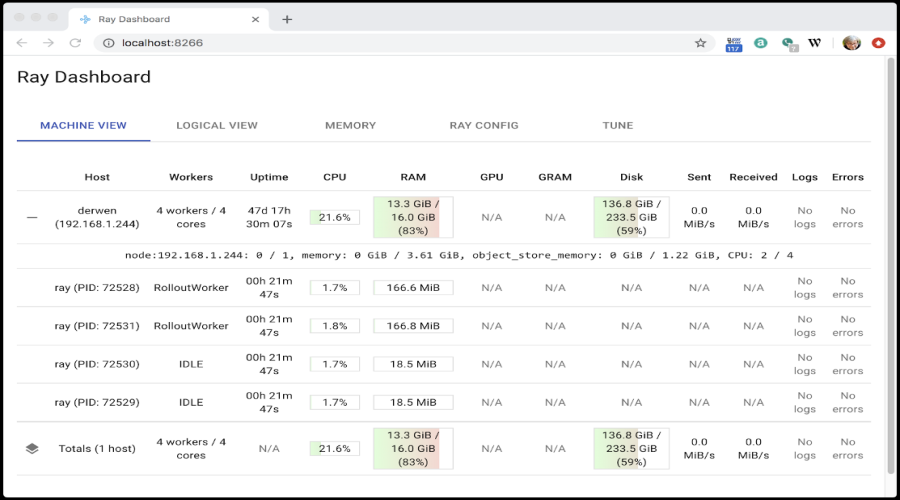

In [ ]:
!curl -sS https://i.imgur.com/VyEW7RX.png> kp.jpg 
img= cv2.imread("kp.jpg")
img= cv2.resize(img, (900,500), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

### Environment configuration

In [ ]:
env_name = "pistonball_v6"

register_env(env_name, lambda config: ParallelPettingZooEnv(env_creator(config)))
test_env  = ParallelPettingZooEnv(env_creator({}))
obs_space = test_env.observation_space
act_space = test_env.action_space

ModelCatalog.register_custom_model("CNNModelV2", CNNModelV2)

def gen_policy(i):
        config = {
            "model": {
                "custom_model": "CNNModelV2",
            },
            "gamma": 0.99,
        }
        return (None, obs_space, act_space, config)

policies = {"policy_0": gen_policy(0)}

policy_ids = list(policies.keys())

/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:64: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  "Function `rng.randint(low, [high, size, dtype])` is marked as deprecated "


### Policy Training

Results are saved in: root/ray_results

In [ ]:
tune.run(
        "PPO",
        name="PPO",
        stop={"timesteps_total": 5000000},
        checkpoint_freq=10,
        local_dir="~/ray_results/" + env_name,
        config={
            # Environment specific
            "env": env_name,
            # General
            "log_level": "ERROR",
            "framework": "torch",
            "num_gpus": 1,
            "num_workers": 4,
            "num_envs_per_worker": 1,
            "compress_observations": False,
            "batch_mode": "truncate_episodes",
            # 'use_critic': True,
            "use_gae": True,
            "lambda": 0.9,
            "gamma": 0.99,
            # "kl_coeff": 0.001,
            # "kl_target": 1000.,
            "clip_param": 0.4,
            "grad_clip": None,
            "entropy_coeff": 0.1,
            "vf_loss_coeff": 0.25,
            "sgd_minibatch_size": 64,
            "num_sgd_iter": 10,  # epoc
            "rollout_fragment_length": 512,
            "train_batch_size": 512,
            "lr": 2e-05,
            "clip_actions": True,
            # Method specific
            "multiagent": {
                "policies": policies,
                "policy_mapping_fn": (lambda agent_id: policy_ids[0]),
            },
        },
    )

AttributeError: ignored

## Load trained policy

* We can then load and restore our trained policy π, and use the policy to choose actions while rendering the environment at each timestep.

* We save the rendered video as a GIF: